### TUGAS BESAR PENGOLAHAN CITRA DIGITAL

## Percobaan 1 & 2

# Mengimpor Library

In [3]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

ModuleNotFoundError: No module named 'sklearn'

Script di atas mengimpor berbagai library yang diperlukan untuk proses pengolahan citra, visualisasi data, serta analisis dan evaluasi model machine learning. Library yang digunakan antara lain yaitu:
1. Library os digunakan untuk manajemen file dan direktori, 
2. cv2 (OpenCV) berfungsi untuk membaca, menampilkan, dan menyimpan gambar. 
3. Library matplotlib.pyplot dan seaborn berguna untuk membuat berbagai jenis plot dan visualisasi data. 
4. numpy dan pandas digunakan untuk operasi numerik dan manipulasi data tabular. 
Untuk pembagian dataset dan validasi silang, script menggunakan sklearn.model_selection, sedangkan evaluasi performa model memanfaatkan berbagai fungsi dari sklearn.metrics seperti akurasi, precision, recall, f1-score, confusion matrix, dan classification report. Fitur tekstur citra dihitung menggunakan skimage.feature melalui fungsi graycomatrix dan graycoprops, sedangkan entropi dihitung dengan scipy.stats.entropy untuk menambah variasi fitur. Dalam proses klasifikasi, digunakan tiga algoritma populer yaitu Random Forest (sklearn.ensemble.RandomForestClassifier), Support Vector Machine (sklearn.svm.SVC), dan K-Nearest Neighbors (sklearn.neighbors.KNeighborsClassifier). Terakhir, sklearn.metrics.ConfusionMatrixDisplay membantu dalam visualisasi confusion matrix sehingga hasil evaluasi lebih mudah dipahami. Dengan keseluruhan library dan fungsinya ini, script menyediakan alat lengkap untuk workflow machine learning berbasis citra, mulai dari preprocessing, ekstraksi fitur, pelatihan model, hingga evaluasi perform

# Preparation & Understanding Data

In [ ]:
def resize_image(img_path, size):
    try:
        img = cv.imread(img_path)
        if img is None:
            raise ValueError(f"Image at {img_path} could not be read.")
        resized_img = cv.resize(img, size)
        return resized_img
    except Exception as e:
        print(f"Error resizing image {img_path}: {e}")
        return None

Fungsi resize_image di atas digunakan untuk membaca gambar dan mengubah ukurannya. Jika file tidak ditemukan atau gambar gagal diresize, fungsi akan mencetak pesan error dan tidak mengembalikan apapun.


Fungsi load_dataset dibawah digunakan untuk membaca dataset citra. Gambar-gambar akan diresize menjadi ukuran 250×250 piksel menggunakan fungsi resize_image. Dataset ini akan mengkategorikan berdasarkan kelas yaitu (Dark, Green, Medium, Light). Untuk setiap kelas hanya diambil maksimal 70 gambar. Fungsi ini akan mengembalikan array citra, array label, nama-nama kelas, dan jumlah gambar yang berhasil dimuat per kelas. Setelah dataset selesai dimuat, script akan menampilkan diagram batang mengenai jumlah gambar per kelas, lalu menyimpan diagram ini sebagai file dataset_distribution.png

Loading dataset...
Dataset loaded with 280 images across 4 classes.


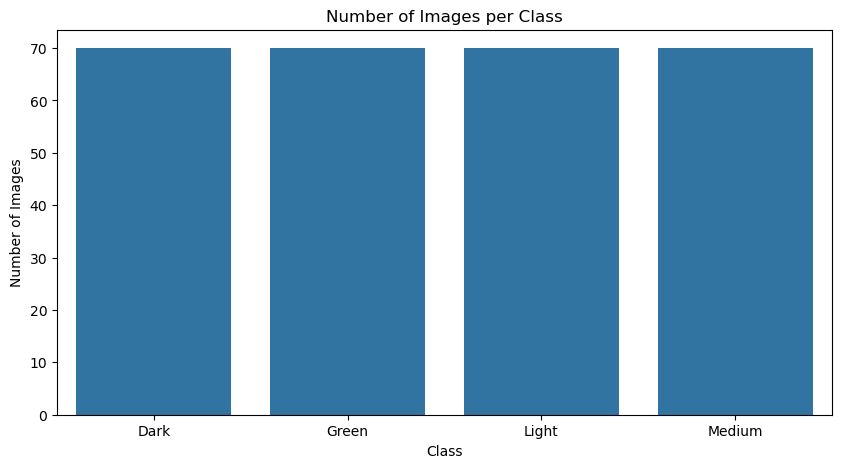

In [ ]:
def load_dataset(dir):
    size = (250,250)
    images = []
    labels = []
    class_names = os.listdir(dir)
    class_counter = {class_name: 0 for class_name in class_names}

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(dir, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if class_counter[class_name] >= 70:
                    break
                img_path = os.path.join(class_dir, file_name)
                img = resize_image(img_path, size)
                if img is not None:
                    images.append(img)
                    labels.append(class_name)
                    class_counter[class_name]+=1
    return np.array(images), np.array(labels), class_names, class_counter


print("Loading dataset...")
images, labels, class_names, class_counter = load_dataset('kopi2')
print(f"Dataset loaded with {len(images)} images across {len(class_names)} classes.")
# Diagram Dataset
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counter.keys()), y=list(class_counter.values()))
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.savefig('dataset_distribution.png')
plt.show()

Fungsi dibawah digunakan untuk menampilkan sample gambar setiap kelas dataset (Dark, Green, Light Medium). Untuk setiap kelas, fungsi ini mengambil satu gambar (gambar ke-10) dan menampilkannya dalam subplot grid menggunakan matplotlib.pyplot. Gambar-gambar tersebut selanjutnya dikonversi dari format BGR ke RGB agar tampil dengan warna yang benar karena mengonversi dari cv ke plt sehingga harus diubah dari BGR ke RGB dan menampilkan label untuk setiap kelasnya.

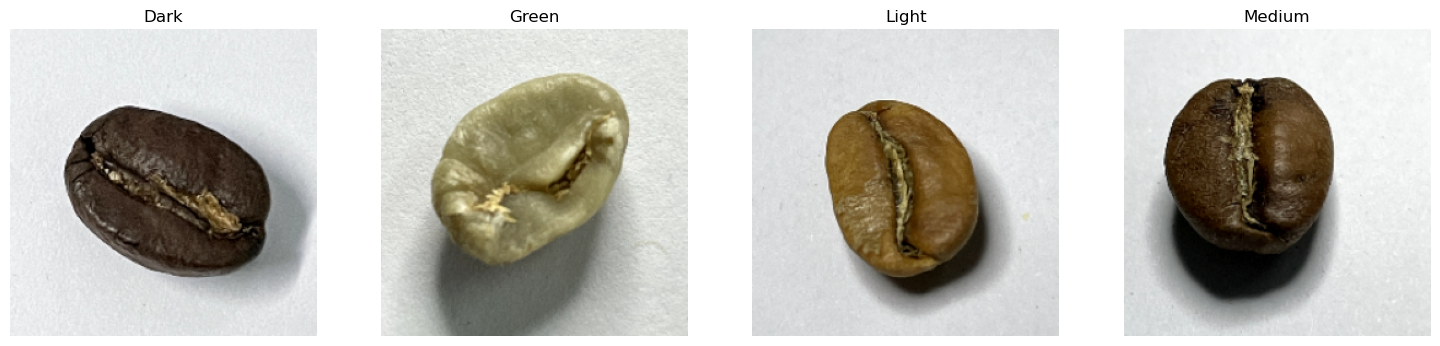

In [ ]:
# Menampilkan gambar sample dari setiap kelas
def show_sample_images(images, labels, class_names):
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        class_images = images[labels == class_name]
        if len(class_images) > 0:
            plt.subplot(3, 4, i + 1)
            plt.imshow(cv.cvtColor(class_images[10], cv.COLOR_BGR2RGB))
            plt.title(class_name)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
show_sample_images(images, labels, class_names)

# Prepocessing

# Grayscale

Fungsi dibawah digunakan untuk mengubah gambar berwarna ke greyscale menggunakan cv2 dan melakukan perulangan untuk setiap kelas dataset lalu menampilkan dalam format greyscale

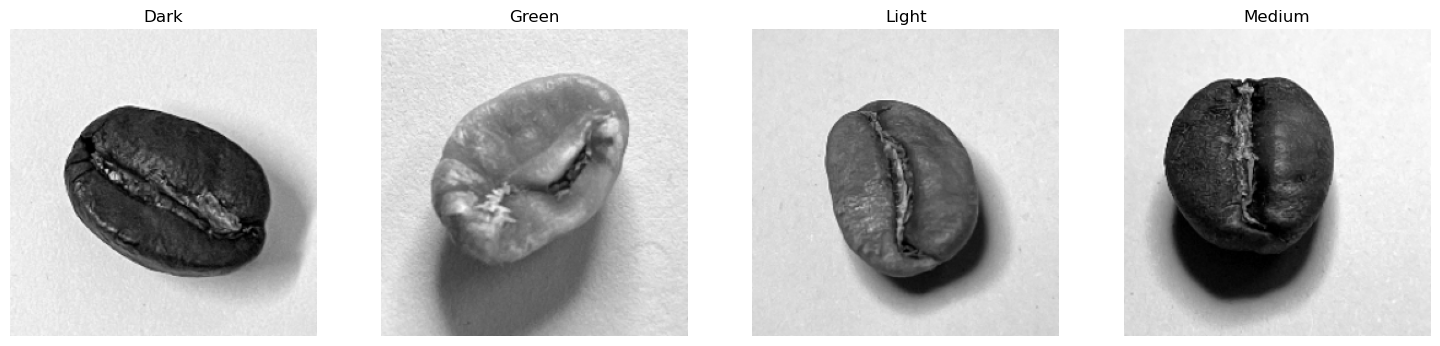

In [ ]:
img_grey = []
for img in images:
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_grey.append(gray)
img_grey = np.array(img_grey)

show_sample_images(img_grey, labels, class_names)

# Normalisasi & Equalisasi

Pada script dibawah terdapat dua fungsi yaitu normalize_image dan equalize_image. Fungsi normalize_image bertujuan untuk  meratakan distribusi intensitas supaya keseluruhan gambar tidak terlalu terang atau gelap. Normalisasi ini dilakukan dengan menyesuaikan nilai minimum dan maksimum pada gambar, jika gambar memiliki nilai piksel yang sama fungsi akan menghasilkan gambar dengan nilai konstan new_min.

Gambar-gambar grayscale yang sudah ada pada fungsi img_grey akan dinormalisasi menggunakan fungsi normalize_image. Hasil normalisasi ini akan disimpan dalam list img_normalized, kemudian akan ditampilkan beberapa contoh hasil gambar normalisasi dari setiap kelas menggunakan fungsi show_sample_images.

Sedangkan equalize_image berfungsi untuk meningkatkan kontras gambar dengan cara mendistribusikan intensitas piksel secara merata di seluruh rentang nilai (0–255) berdasarkan histogram. Fungsi ini hanya bekerja pada gambar grayscale; jika inputnya bukan grayscale, maka fungsi akan menampilkan error.

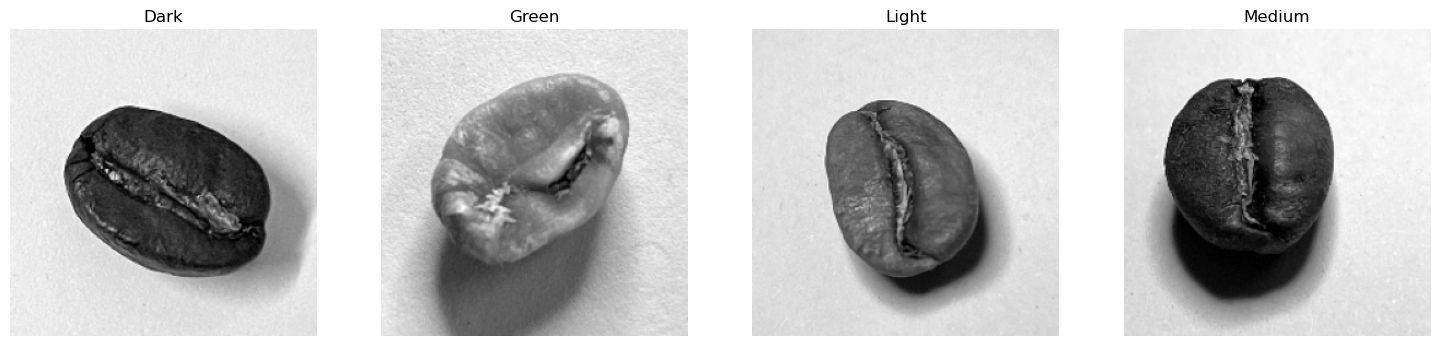

In [ ]:

def normalize_image(img, new_min=0, new_max=255):
    """
    Normalisasi gambar ke range [new_min, new_max]
    """
  
    img = img.astype(np.float32)
  
    old_min = np.min(img)
    old_max = np.max(img)
    
   
    if old_max == old_min:
        return np.zeros_like(img, dtype=np.uint8) + new_min

    normalized = ((img - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min
    
    
    return normalized.astype(np.uint8)


def equalize_image(img):
    """
    Ekualisasi histogram untuk meningkatkan kontras gambar.
    """
    try:
        # Pastikan gambar dalam format grayscale
        if len(img.shape) == 3:
            raise ValueError("Input image must be grayscale.")
        
        # Ekualisasi histogram
        equalized_img = cv.equalizeHist(img)
        return equalized_img
    except Exception as e:
        print(f"Error during histogram equalization: {e}")
        return None

# Contoh penggunaan fungsi ekualisasi
# img_normalized = []
# for img in img_grey:
#     eq_img = equalize_image(img)
#     img_normalized.append(eq_img)
# img_normalized = np.array(img_normalized)



img_normalized = []
for img in img_grey:
    norm_img = normalize_image(img)
    img_normalized.append(norm_img)
img_normalized = np.array(img_normalized)

# Tampilkan sample gambar
show_sample_images(img_normalized, labels, class_names)

# Sharpening

Fungsi sharpening dibawah menggunakan filter kernel 3x3 untuk mempertajam detail gambar. Kernel [[0, -1, 0], [-1, 5, -1], [0, -1, 0]] kernel ini akan menekankan perbedaan antara piksel pusat dengan sekitarnya. Fungsi ini diterapkan pada setiap gambar hasil normalisasi sebelumnya yang disimpan pada fungsi img_normalized dengan cv.filter2D. Hasilnya, setiap gambar menjadi lebih tajam dan detailnya lebih terlihat. Setelah semua gambar diolah, gambar-gambar hasil sharpening ditampilkan menggunakan fungsi show_sample_images

In [ ]:
# def sharpening(image):
#     kernel = np.array([[ 0, -1,  0],
#                        [-1,  5, -1],
#                        [ 0, -1,  0]])
#     return cv.filter2D(image, -1, kernel)

# img_smooth = []
# for img in img_normalized:
#     sharpened_img = sharpening(img)
#     img_smooth.append(sharpened_img)
# img_smooth = np.array(img_smooth)
# show_sample_images(img_smooth, labels, class_names)


# Smoothing

#Fungsi smoothing dibawah menggunakan filter kernel 3x3 untuk memperhalus gambar. Kernel ini memiliki bobot yang lebih besar di pusat (1/5) dan lebih kecil di sekitarnya (1/10), sehingga akan membantu mengurangi noise tapi tetap menjaga ketajaman detail gambar. Fungsi cv.filter2D dari OpenCV digunakan untuk mengaplikasikan filter ini ke setiap gambar hasil normalisasi yang disimpan pada fungsi img_normalized. Setelah semua gambar dihaluskan, hasilnya disimpan ke array img_smooth dan beberapa contoh hasil smoothing ditampilkan menggunakan fungsi show_sample_images.

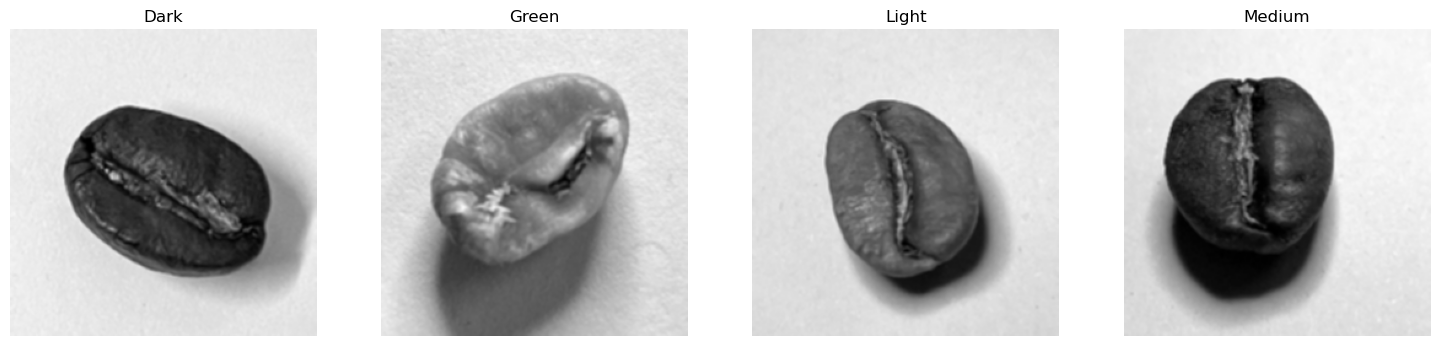

In [ ]:
def smoothening(image):
    kernel = np.array([[1/10, 1/10, 1/10],
                             [1/10, 1/5,1/10],
                             [1/10, 1/10, 1/10]])
    return cv.filter2D(image, -1, kernel)

img_smooth = []
for img in img_normalized:
    smoothened_img = smoothening(img)
    img_smooth.append(smoothened_img)
img_smooth = np.array(img_smooth)
show_sample_images(img_smooth, labels, class_names)

# Feature Extraction GLCM

In [ ]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

Script di atas adalah fungsi glcm, yang digunakan untuk menghitung matriks GLCM untuk sebuah citra pada sudut tertentu. Fungsi ini menerima dua parameter, yaitu image (citra grayscale tunggal) dan derajat. Sudut derajat ini diterjemahkan ke dalam bentuk radian (0°, 45°, 90°, 135°) sesuai standar pengolahan GLCM. Jika sudut yang dimasukkan tidak valid, maka akan ditampilkan error. Fungsi graycomatrix dari library skimage.feature digunakan untuk menghasilkan matriks GLCM dengan jarak antar piksel 1, symmetric=True, dan normed=True. Hasil akhirnya adalah matriks GLCM untuk citra tersebut pada sudut yang diinginkan.

In [ ]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

Script di atas adalah fungsi correlation, yang digunakan untuk menghitung nilai korelasi dari sebuah matriks GLCM (Gray-Level Co-occurrence Matrix). Fungsi ini menerima satu parameter, yaitu matriks, yang merupakan GLCM yang sudah dihasilkan sebelumnya. Fungsi ini memanfaatkan graycoprops dari library skimage.feature, yang secara otomatis menghitung nilai korelasi berdasarkan rumus standar GLCM (menggunakan rata-rata, standar deviasi, dan nilai-nilai dalam GLCM). Hasil akhirnya adalah nilai korelasi tunggal ([0,0]), yang menunjukkan seberapa besar hubungan linear antara piksel dan tetangganya di citra.

In [ ]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

Script di atas adalah fungsi dissimilarity, yang digunakan untuk menghitung nilai ketidakserupaan dari sebuah matriks GLCM. Fungsi ini menerima satu parameter, yaitu matriks, yang merupakan GLCM yang sudah dihasilkan sebelumnya. Fungsi ini menggunakan graycoprops dari library skimage.feature, yang secara otomatis menghitung nilai dissimilarity berdasarkan formula standar GLCM (menggunakan selisih absolut antara indeks baris dan kolom dikalikan dengan nilai dalam GLCM). Hasil akhirnya adalah nilai dissimilarity tunggal ([0,0]), yang menunjukkan seberapa besar ketidakserupaan tekstur pada citra.

In [ ]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

Script di atas merupakan fungsi homogenity, yang digunakan untuk menghitung nilai homogenitas dari sebuah matriks GLCM. Fungsi ini menerima satu parameter yaitu matriks, yang merupakan matriks GLCM. Prosesnya memanfaatkan fungsi graycoprops dari pustaka skimage.feature untuk secara otomatis menghitung nilai homogenitas, dan mengembalikan elemen pertama dari hasilnya sebagai nilai homogenitas.

In [ ]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

Script di atas adalah fungsi contrast, yang digunakan untuk menghitung nilai kontras matriks GLCM . Fungsi ini menerima satu parameter, yaitu matriks, yang merupakan GLCM yang sudah dihasilkan sebelumnya. Fungsi ini memanfaatkan graycoprops dari library skimage.feature, yang secara otomatis menghitung nilai kontras berdasarkan rumus standar GLCM. Hasil akhirnya adalah nilai kontras tunggal (\[0,0]), yang menunjukkan perbedaan intensitas antara piksel dan tetangganya di citra.

In [ ]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

Script di atas merupakan fungsi ASM, yang digunakan untuk menghitung nilai Angular Second Moment (ASM) dari sebuah matriks GLCM. Fungsi ini menerima satu parameter, yaitu matriks, yang merupakan GLCM yang sudah dihasilkan sebelumnya. Fungsi ini menggunakan graycoprops dari library skimage.feature untuk secara otomatis menghitung nilai ASM berdasarkan rumus standar GLCM. Hasil yang dikembalikan adalah nilai ASM tunggal (\[0,0]), yang menunjukkan tingkat homogenitas atau keseragaman tekstur pada citra.

In [ ]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

Script di atas merupakan fungsi energy, yang digunakan untuk menghitung nilai energi matriks GLCM . Fungsi ini menerima satu parameter, yaitu matriks, yang merupakan GLCM yang sudah dihasilkan sebelumnya. Fungsi ini menggunakan graycoprops dari library skimage.feature untuk secara otomatis menghitung nilai energi berdasarkan rumus standar GLCM. Nilai energi yang dikembalikan ([0,0]) menunjukkan tingkat kekuatan atau kerapatan tekstur pada citra

In [ ]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Script di atas merupakan fungsi entropyGlcm, yang digunakan untuk menghitung nilai entropi dari sebuah matriks GLCM. Fungsi ini menerima satu parameter yaitu matriks, yang merupakan matriks GLCM. Prosesnya memanfaatkan fungsi entropy dari library scipy.stats yang secara otomatis menghitung entropi berdasarkan distribusi probabilitas elemen dalam matriks tersebut (dengan meratakan matriks menjadi satu dimensi). Nilai yang dikembalikan merupakan tingkat ketidakteraturan atau kompleksitas tekstur pada citra.

In [ ]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(img_smooth)):
    D0 = glcm(img_smooth[i], 0)
    D45 = glcm(img_smooth[i], 45)
    D90 = glcm(img_smooth[i], 90)
    D135 = glcm(img_smooth[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Script di atas digunakan untuk menghitung matriks GLCM dari setiap citra yang terdapat dalam list img_smooth pada empat arah sudut yaitu 0°, 45°, 90°, dan 135°. Pertama membuat empat list kosong yang akan menampung hasil GLCM untuk setiap arah sudut. Selanjutnya, untuk setiap citra dalam img_smooth, fungsi glcm dipanggil dengan parameter sudut yang sesuai, kemudian hasilnya dimasukkan ke dalam list. Hasil akhirnya berup kumpulan matriks GLCM dari berbagai orientasi sudut, yang berguna untuk analisis tekstur citra.

In [ ]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


Script di atas membuat list kosong untuk menyimpan nilai fitur tekstur yang dihitung dari matriks GLCM pada empat arah sudut sebelumnya. Setiap fitur tekstur mempunyai empat list terpisah yang khusus menampung hasil perhitungan pada masing-masing sudut. 

In [ ]:
for i in range(len(img_smooth)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

Script di atas melakukan perhitungan nilai correlation dari matriks GLCM untuk setiap citra yang ada pada img_smooth. Untuk setiap indeks citra, fungsi correlation dipanggil dengan matriks GLCM pada sudut yang bersesuaian, kemudian hasilnya disimpan ke dalam list correlation0, correlation45, correlation90, dan correlation135. Script ini nantinya akan mengumpulkan nilai korelasi tekstur dari seluruh citra pada masing-masing arah.

In [ ]:
for i in range(len(img_smooth)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

Script di atas melakukan perhitungan nilai kontras dari matriks GLCM untuk setiap citra yang ada pada img_smooth. Untuk setiap indeks citra, fungsi contrast dipanggil dengan matriks GLCM pada sudut yang bersesuaian, kemudian hasilnya disimpan ke dalam list Kontras0, Kontras45, Kontras90, dan Kontras135. Script ini nantinya akan mengumpulkan nilai kontras tekstur dari seluruh citra pada masing-masing arah.

In [ ]:
for i in range(len(img_smooth)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

Script di atas melakukan perhitungan nilai dissimilarity dari matriks GLCM untuk setiap citra yang ada pada img_smooth. Pada setiap indeks citra, fungsi dissimilarity dipanggil dengan matriks GLCM pada sudut yang sesuai, kemudian hasilnya disimpan ke dalam list dissimilarity0, dissimilarity45, dissimilarity90, dan dissimilarity135. Script ini bertujuan mengumpulkan nilai dissimilarity tekstur dari seluruh citra pada masing-masing arah.

In [ ]:
for i in range(len(img_smooth)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

Script di atas melakukan perhitungan nilai homogenitas dari matriks GLCM untuk setiap citra yang ada pada img_smooth. Untuk setiap indeks citra, fungsi homogenity dipanggil dengan matriks GLCM pada sudut yang sesuai, lalu hasilnya disimpan ke dalam list homogenity0, homogenity45, homogenity90, dan homogenity135. Script ini mengumpulkan nilai homogenitas tekstur dari seluruh citra pada masing-masing arah sudut.

In [ ]:
for i in range(len(img_smooth)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

Script di atas melakukan perhitungan nilai entropi dari matriks GLCM untuk setiap citra yang ada pada img_smooth. Untuk setiap indeks citra, fungsi entropyGlcm dipanggil dengan matriks GLCM pada sudut yang sesuai, kemudian hasilnya disimpan ke dalam list entropy0, entropy45, entropy90, dan entropy135. Script ini mengumpulkan nilai entropi tekstur dari seluruh citra pada masing-masing arah sudut.

In [ ]:
for i in range(len(img_smooth)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

Script di atas melakukan perhitungan nilai Angular Second Moment (ASM) dari matriks GLCM untuk setiap citra dalam img_smooth. Pada setiap iterasi, fungsi ASM dipanggil dengan matriks GLCM pada sudut yang sesuai, lalu hasilnya disimpan ke dalam list ASM0, ASM45, ASM90, dan ASM135. Script ini mengumpulkan nilai ASM yang merepresentasikan tingkat homogenitas tekstur dari seluruh citra pada masing-masing arah sudut.

In [ ]:
for i in range(len(img_smooth)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Script di atas melakukan perhitungan nilai energi dari matriks GLCM untuk setiap citra dalam img_smooth. Pada setiap iterasi, fungsi energy dipanggil dengan matriks GLCM pada sudut yang sesuai, kemudian hasilnya disimpan ke dalam list energy0, energy45, energy90, dan energy135. Script ini mengumpulkan nilai energi yang menggambarkan kekuatan atau intensitas tekstur dari seluruh citra pada masing-masing arah sudut.

# Write the extraction's results to CSV

In [ ]:
dataTable = {'Filename': 'nopal', 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,nopal,Dark,50.244096,79.775633,34.618538,84.046790,0.479781,0.408548,0.506698,0.417833,...,0.005711,0.004515,0.074340,0.065697,0.075568,0.067194,0.995807,0.993354,0.997112,0.992999
1,nopal,Dark,38.688064,106.386332,58.035582,79.813906,0.509181,0.427588,0.493871,0.431963,...,0.015722,0.012192,0.123029,0.110764,0.125389,0.110417,0.997194,0.992302,0.995791,0.994225
2,nopal,Dark,42.985671,86.728666,38.105108,68.267334,0.440198,0.367427,0.466215,0.382920,...,0.005077,0.003737,0.067518,0.060190,0.071254,0.061129,0.996163,0.992277,0.996600,0.993921
3,nopal,Dark,34.313028,79.198303,39.370410,60.247544,0.460007,0.389895,0.472912,0.405498,...,0.008429,0.006304,0.086954,0.079001,0.091810,0.079398,0.996992,0.993072,0.996550,0.994730
4,nopal,Dark,37.755711,58.903873,38.586040,86.224287,0.438114,0.389674,0.477883,0.375284,...,0.007825,0.005649,0.081599,0.074557,0.088460,0.075157,0.996845,0.995089,0.996776,0.992811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,nopal,Medium,46.197767,78.540330,36.155743,80.383091,0.475940,0.405271,0.491418,0.405816,...,0.003611,0.002671,0.058454,0.051804,0.060091,0.051678,0.996863,0.994677,0.997545,0.994552
276,nopal,Medium,36.802940,70.249496,31.662602,61.336769,0.512449,0.438105,0.518533,0.438474,...,0.004998,0.003762,0.069069,0.061434,0.070696,0.061338,0.996633,0.993590,0.997103,0.994403
277,nopal,Medium,46.538715,93.488331,35.528675,63.810406,0.506345,0.434400,0.516093,0.451505,...,0.004614,0.003555,0.066555,0.059064,0.067926,0.059620,0.996472,0.992928,0.997307,0.995173
278,nopal,Medium,53.869847,83.383091,43.710570,103.083515,0.486793,0.434420,0.503627,0.421195,...,0.013262,0.010054,0.112912,0.101625,0.115162,0.100270,0.995344,0.992808,0.996222,0.991109


# Features Selection
pada bagian seleksi fitur ini bisa menggunakan metode seperti

PCA
LDA
t-SNE
Chi-square
ANOVA
Autoencoder
correlation
dll
berikut contoh menggunakan correlation:

<Axes: >

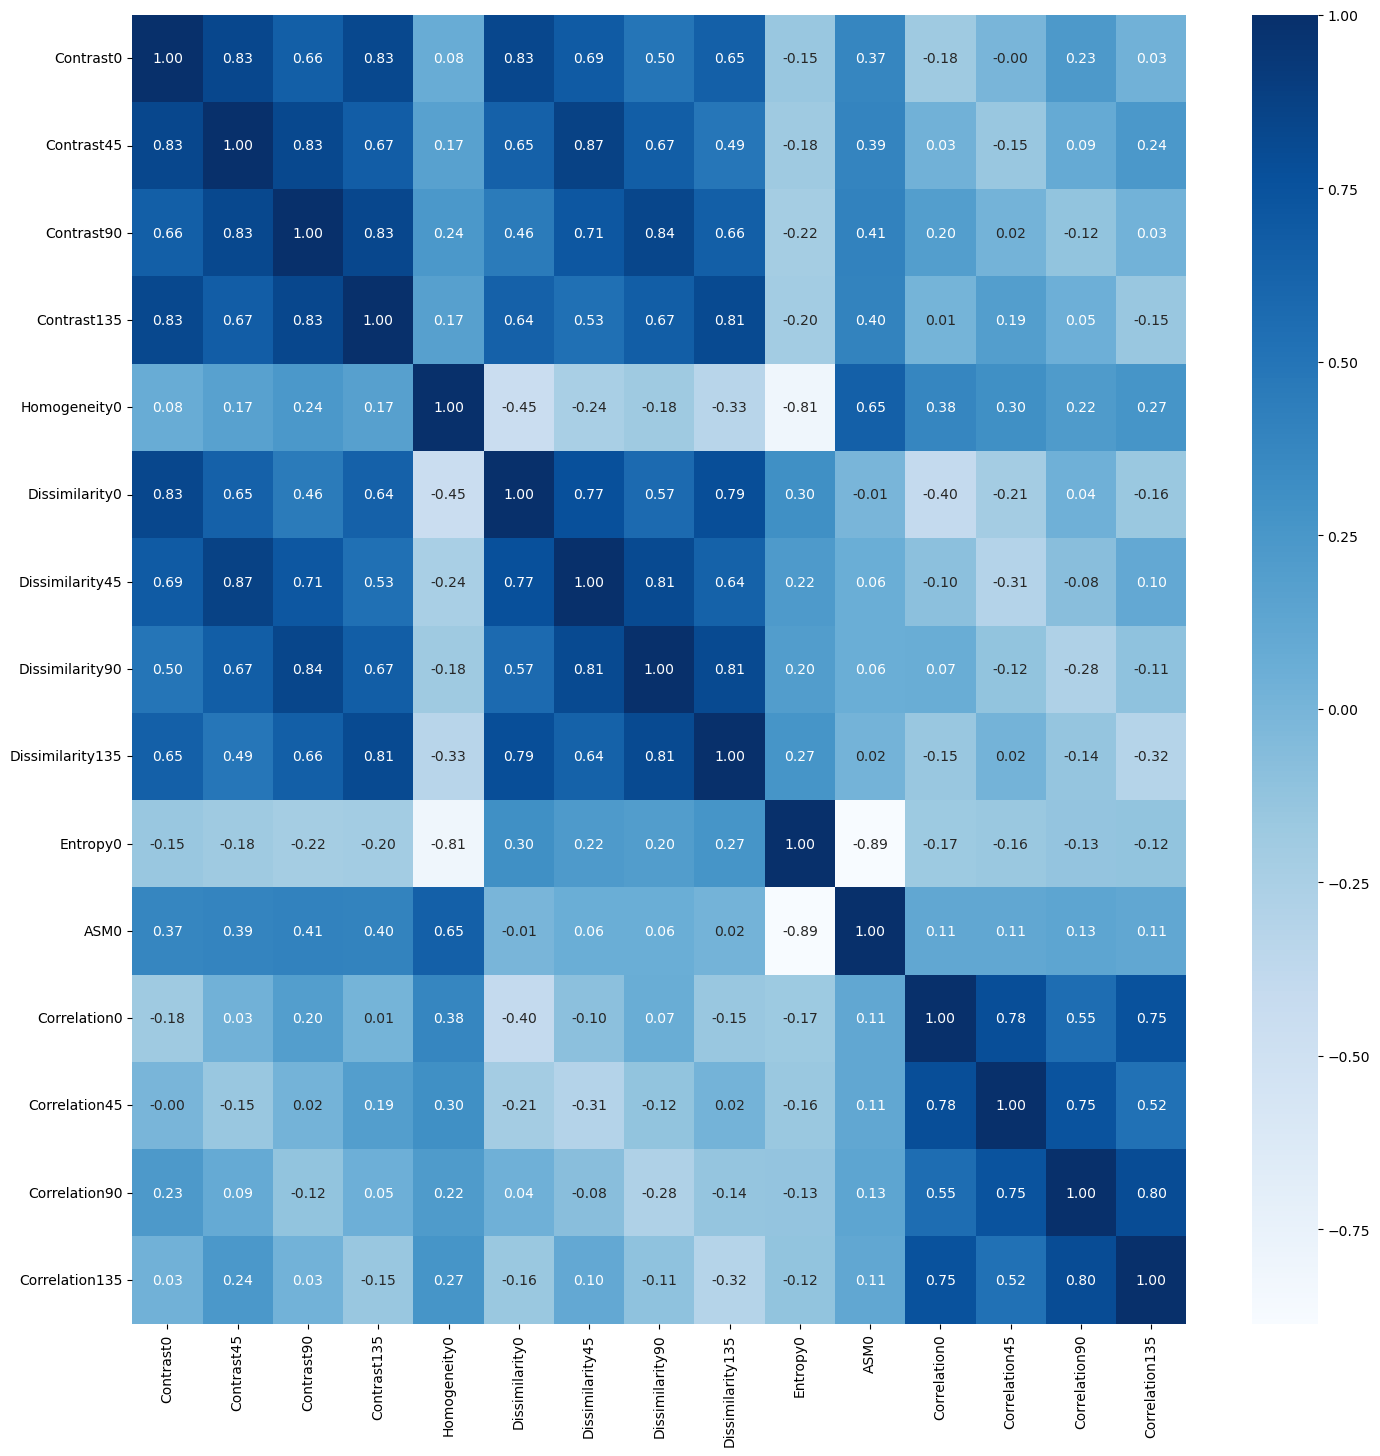

In [ ]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

# Splitting Data

In [ ]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(224, 15)
(56, 15)


# Feature Normalization
berikut metode normalisasi yang bisa digunakan:

- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll
berikut contoh menggunakan Standardization (Z-score):

In [ ]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

# Modeling

# Define Model

In [ ]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

# Train Random Forest Classifier

In [ ]:
rf.fit(X_train, y_train)

print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

        Dark       0.93      0.98      0.96        55
       Green       1.00      1.00      1.00        57
       Light       0.97      1.00      0.98        57
      Medium       0.98      0.89      0.93        55

    accuracy                           0.97       224
   macro avg       0.97      0.97      0.97       224
weighted avg       0.97      0.97      0.97       224

[[54  0  0  1]
 [ 0 57  0  0]
 [ 0  0 57  0]
 [ 4  0  2 49]]
Accuracy: 0.96875

------Testing Set------
              precision    recall  f1-score   support

        Dark       0.67      0.80      0.73        15
       Green       0.85      0.85      0.85        13
       Light       0.62      0.62      0.62        13
      Medium       0.50      0.40      0.44        15

    accuracy                           0.66        56
   macro avg       0.66      0.67      0.66        56
weighted avg       0.65      0.66      0.65        56

[

# Train SVM Classifier

In [ ]:
svm.fit(X_train, y_train)

print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

        Dark       0.82      0.85      0.84        55
       Green       0.96      0.91      0.94        57
       Light       0.90      0.96      0.93        57
      Medium       0.85      0.80      0.82        55

    accuracy                           0.88       224
   macro avg       0.88      0.88      0.88       224
weighted avg       0.88      0.88      0.88       224

[[47  0  0  8]
 [ 0 52  5  0]
 [ 0  2 55  0]
 [10  0  1 44]]
Accuracy: 0.8839285714285714

------Testing Set------
              precision    recall  f1-score   support

        Dark       0.79      0.73      0.76        15
       Green       0.92      0.92      0.92        13
       Light       0.86      0.92      0.89        13
      Medium       0.73      0.73      0.73        15

    accuracy                           0.82        56
   macro avg       0.82      0.83      0.83        56
weighted avg       0.82      0.82      0.82 

# Train KNN Classifier

In [ ]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

        Dark       0.81      0.85      0.83        55
       Green       0.98      0.86      0.92        57
       Light       0.80      0.96      0.87        57
      Medium       0.81      0.69      0.75        55

    accuracy                           0.84       224
   macro avg       0.85      0.84      0.84       224
weighted avg       0.85      0.84      0.84       224

[[47  0  0  8]
 [ 0 49  8  0]
 [ 0  1 55  1]
 [11  0  6 38]]
Accuracy: 0.84375

------Testing Set------
              precision    recall  f1-score   support

        Dark       0.85      0.73      0.79        15
       Green       0.92      0.92      0.92        13
       Light       0.80      0.92      0.86        13
      Medium       0.73      0.73      0.73        15

    accuracy                           0.82        56
   macro avg       0.83      0.83      0.82        56
weighted avg       0.82      0.82      0.82        56



# Evaluation With Confusion Matrix

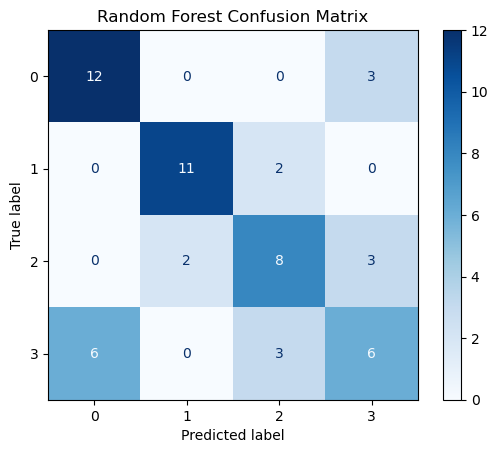

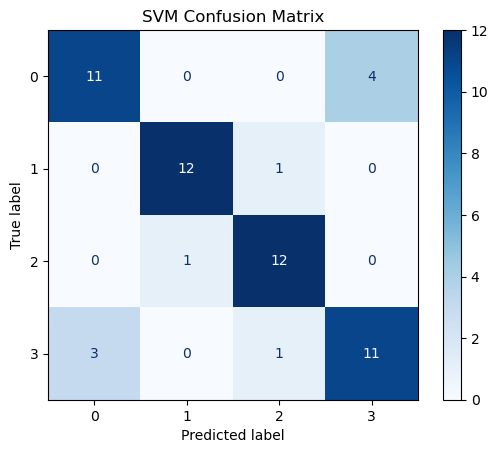

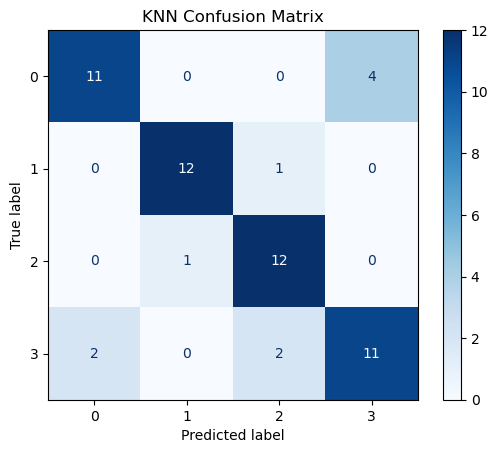

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")